In [1]:
import jupyter_dash
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from matplotlib.pyplot import suptitle
import plotly.express as px, plotly.io as pio, plotly.offline as pyo
import plotly.graph_objs as go, plotly.subplots as sp
from plotly.subplots import make_subplots
import dash, dash_bootstrap_components as dbc
from dash import dash_table
from dash import dcc, html
from dash.dependencies import Input, Output, State
import os
from sqlalchemy import create_engine, text
from tkinter import Button
from jupyter_dash import JupyterDash
pd.set_option('mode.chained_assignment', None)
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

- We have encapsulated specific data preparation tasks within a Python def function to streamline our workflow.

In [2]:
def Label_Encoder(df = None):
    from sklearn.preprocessing import LabelEncoder
    cat_cols = [col for col in df.columns if df[col].dtypes in ["object", "category"] and df[col].nunique() < 60]
    for col in cat_cols:
        le = LabelEncoder() 
        df[col] = le.fit_transform(df[col])
    
    return df

def Log_Transform(df = None):
    num_cols = [col for col in df.columns if df[col].dtypes in ["int64", "float64"]]
    for col in num_cols:
        if (df[col] < 0).any():
            continue
        else:
            df[col] = np.log1p(df[col])
    
    return df


def Regression_Scores(predict_values = None, y_test_values = None):
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    score = mean_squared_error(predict_values, y_test_values)
    score2 = mean_absolute_error(predict_values, y_test_values)
    print("Mean Squared Error", score)
    print("Mean Absolute Eror", score2)
    

    
def Skewness_Rate(df = None):
    from scipy.stats import skew
    for i in df.select_dtypes(include = ["float64", "int64"]).columns:
         if skew(df[i]) > 1:
                skew_rates = print(f"Column Name = {i}, Skewness Rate = {skew(df[i])}")
         else:
             continue
         
def evaluate_metrics(yt, yp):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

def Standard_Scaler(X_train = None, X_test = None):
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [4]:
data_1 = pd.read_csv(r"C:\Users\rocks\OneDrive\Masaüstü\MachineLearning\churn-bigml-20.csv")
data_2 = pd.read_csv(r"C:\Users\rocks\OneDrive\Masaüstü\MachineLearning\churn-bigml-80.csv")

In [5]:
data = pd.concat([data_1, data_2], axis = 0).reset_index(drop = True)

- Our dataset originates from a telecommunications company, and our objective is to predict customer churn.

In [6]:
data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,184.500,97,31.370,351.600,80,29.890,215.800,90,9.710,8.700,4,2.350,1,False
1,IN,65,415,No,No,0,129.100,137,21.950,228.500,83,19.420,208.800,111,9.400,12.700,6,3.430,4,True
2,NY,161,415,No,No,0,332.900,67,56.590,317.800,97,27.010,160.600,128,7.230,5.400,9,1.460,4,True
3,SC,111,415,No,No,0,110.400,103,18.770,137.300,102,11.670,189.600,105,8.530,7.700,6,2.080,2,False
4,HI,49,510,No,No,0,119.300,117,20.280,215.100,109,18.280,178.700,90,8.040,11.100,1,3.000,1,False


In [7]:
data.shape

(3333, 20)

In [8]:
data.describe().style.background_gradient(cmap = "BuPu_r")

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [9]:
data["Churn"].replace({False : 0, True : 1}, inplace = True)

- By employing a correlation matrix, we are attempting to identify columns that convey redundant information. As observed, 'Total Night Minutes' and 'Total Night Charges' carry the same information. To enhance the performance of our model, we will remove one of these variables.

In [10]:
num_cols = [col for col in data.columns if data[col].dtypes in ["float64", "int64"] and data[col].nunique() > 12]
import plotly.figure_factory as ff
corr_matrix = data[num_cols].corr()
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))
z = np.where(mask, corr_matrix.values, np.nan)

Fig_1 = ff.create_annotated_heatmap(z = z, x = list(corr_matrix.columns), y = list(corr_matrix.index), 
    annotation_text = np.round(z, 2), colorscale = 'Viridis', showscale = True)

Fig_1.update_layout(height = 1000, title = {"text" : "Correlation Matrix", "x" : 0.5, "y" : 0.99}, title_font = dict(size = 18))
Fig_1.update_layout(paper_bgcolor = "orange", plot_bgcolor = "orange")
Fig_1.show()

- As previously mentioned, we have removed the 'Total Day Minutes' variable. As a result, our dataset is now more streamlined.

In [11]:
data = data.drop("Total day minutes", axis = 1)

- Here, we are utilizing the value_counts method with the normalize=True parameter to examine the class distribution of our target variable. As observed, approximately 14% of our data consists of churned customers, while 85% consists of non-churned customers. This could pose a challenge for our model and may necessitate the application of downsampling or upsampling techniques. We will make a determination on this matter as we evaluate model performance in subsequent steps.

In [12]:
freq = data["Churn"].value_counts(normalize = True).reset_index().rename(columns = {"proportion" : "Percent", "index" : "Churn"})
Fig_2 = go.Figure(data = [go.Pie(labels = freq['Churn'], values = freq['Percent'], hovertemplate = "<br> Churn %{label}</br> <br> Percent %{value}</br>", marker = dict(colors = ["yellow", "green"]))])
Fig_2.update_layout(paper_bgcolor = "orange", plot_bgcolor = "orange", title = "Sınıf Dağılımı")
Fig_2.show()

In [13]:
data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,LA,117,408,No,No,0,97,31.370,351.600,80,29.890,215.800,90,9.710,8.700,4,2.350,1,0
1,IN,65,415,No,No,0,137,21.950,228.500,83,19.420,208.800,111,9.400,12.700,6,3.430,4,1
2,NY,161,415,No,No,0,67,56.590,317.800,97,27.010,160.600,128,7.230,5.400,9,1.460,4,1
3,SC,111,415,No,No,0,103,18.770,137.300,102,11.670,189.600,105,8.530,7.700,6,2.080,2,0
4,HI,49,510,No,No,0,117,20.280,215.100,109,18.280,178.700,90,8.040,11.100,1,3.000,1,0


- Here, we are further exploring our dataset by examining the bivariate correlation between the input variables and our target variable, 'Churn'. This helps us to better understand how each feature potentially influences the likelihood of customer churn.

In [14]:
from plotly.validators.heatmap import _hoverlabel


data_corr = [data[col].corr(data["Churn"]) if data[col].dtypes in ["int64", "float64"] else None for col in data.columns]
corr_df = pd.DataFrame({'Column': data.columns, 'Correlation': data_corr})
corr_df = corr_df.dropna().sort_values(by = "Correlation", ascending = False)
color = ["white"]
Fig_3 = px.bar(corr_df, x='Column', y='Correlation', text = "Column", color_discrete_sequence = color)
Fig_3.update_layout(height = 800, hovermode = "x unified", hoverlabel = dict(bgcolor = "white", font_size = 16, font_family = "Arial", font_color = "black"),
                    paper_bgcolor = "orange", plot_bgcolor = "orange", title = {"text" : "Correlation rate by Churn", "x" : 0.5, "y" : 0.96, "font": {"family" : "Arial", "size" : 24}})
Fig_3.show()

# ML ALGORİTHMS

- Before building the model, we partition our data into input (X) and target (Y) variables.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

X = [col for col in data.columns if col != "Churn"]
X = data[X]

y = data["Churn"]

- We are transforming our categorical columns into numerical variables using the Label_Encoder function that we previously defined.

In [16]:
X = Label_Encoder(X)

- We are splitting our data into training and test sets, ensuring a stratified distribution by setting stratify=y. This guarantees that both the test and training sets have approximately 14% of the data labeled as '1'. If we were not to use this method, there could be a risk of receiving a training set with an imbalanced ratio, such as 95% '0's and 5% '1's, which would significantly impact the learning capacity of our model. Therefore, to maintain the integrity of the data distribution, we ensure a 14% representation in both the test and training sets.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 142, test_size = 0.30, stratify = y)

print("X_train shape is :", X_train.shape)
print("X_test shape is : ", X_test.shape)

X_train, X_test = Standard_Scaler(X_train, X_test)

X_train shape is : (2333, 18)
X_test shape is :  (1000, 18)


- For this dataset, we will experiment with three different machine learning models: K-Nearest Neighbors (KNN), Support Vector Machines (SVM), and RandomForest. We will select the model that yields the highest performance score and proceed to fine-tune it for our final analysis.

# KNN

In [18]:
model = KNeighborsClassifier(n_neighbors = 5)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

evaluate_metrics(y_pred, y_test)

{'accuracy': 0.886,
 'recall': 0.8444444444444444,
 'precision': 0.2620689655172414,
 'f1score': 0.4000000000000001}

# SVM

In [19]:
svm_model = SVC(kernel = "linear")

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

evaluate_metrics(y_pred, y_test)

c:\Users\rocks\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



{'accuracy': 0.855, 'recall': 0.0, 'precision': 0.0, 'f1score': 0.0}

In [20]:
svm_model2 = SVC(kernel = "rbf")

svm_model2.fit(X_train, y_train)

y_pred = svm_model2.predict(X_test)

evaluate_metrics(y_pred, y_test)

{'accuracy': 0.9,
 'recall': 0.8461538461538461,
 'precision': 0.3793103448275862,
 'f1score': 0.5238095238095238}

In [21]:
svm_model3 = SVC(kernel = "poly")

svm_model3.fit(X_train, y_train)

y_pred = svm_model3.predict(X_test)

evaluate_metrics(y_pred, y_test)

{'accuracy': 0.902,
 'recall': 0.8133333333333334,
 'precision': 0.4206896551724138,
 'f1score': 0.5545454545454546}

In [22]:
svm_model4 = SVC(kernel = "sigmoid")

svm_model4.fit(X_train, y_train)

y_pred = svm_model4.predict(X_test)

evaluate_metrics(y_pred, y_test)

{'accuracy': 0.829,
 'recall': 0.26785714285714285,
 'precision': 0.10344827586206896,
 'f1score': 0.14925373134328357}

In [23]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()

model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

evaluate_metrics(y_pred, y_test)

{'accuracy': 0.953,
 'recall': 0.9224137931034483,
 'precision': 0.7379310344827587,
 'f1score': 0.8199233716475096}

- As observed, Random Forest has emerged as the model delivering the highest performance. Based on the evaluate metrics and the F1 score, we can conclude that Random Forest is the most appropriate model for this particular dataset. We will now proceed with the necessary optimizations to enhance the model's generalization capabilities.

# GridSearch Cross-Validation

- We have defined the necessary parameters for both cross-validation and grid search in a dictionary and configured the settings accordingly.

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [10, 50, 100, 200], 
    'max_features': ['sqrt', 'log2'], 
    'max_depth': [None, 10, 20, 30, 40, 50], 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap': [True, False],  
    'criterion': ['gini', 'entropy']}

model = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, n_jobs = 1, scoring = 'accuracy', cv = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

evaluate_metrics(y_pred, y_test)

Based on the above metrics, our model performs quite well, except for a slightly lower precision value. In our scenario, the most important metric is recall because, according to the cost structure of our model, mislabeling a customer who will churn as a '0' is more costly. However, we will still attempt to further optimize the model by adjusting the threshold values to achieve a better balance.

Additionally, we are comparing the training and testing errors to check for overfitting. The closeness of the two values is a strong indicator that our model is not overfitting.

In [ ]:
train_score = model.best_score_
test_score = model.score(X_test, y_test)

print(f"Training Score: {train_score}")
print(f"Test Score: {test_score}")

Training Score: 0.9511372931045574
Test Score: 0.95


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

array([[841,  36],
       [ 14, 109]], dtype=int64)

We are plotting the confusion matrix for our model

In [ ]:
import plotly.figure_factory as ff
confusion = np.array([[842, 38], [13, 107]])
z = confusion
x = ['Predicted Negative', 'Predicted Positive']
y = ['Actual Negative', 'Actual Positive']

# Heatmap oluşturma
Fig_4 = ff.create_annotated_heatmap(z, x = x, y = y, colorscale = 'Viridis')

# Layout ayarları
Fig_4.update_layout(title = {"text" : "Confusion Matrix", "x" : 0.52, "y" : 0.96}, xaxis = dict(title = 'Predicted label'), yaxis=dict(title = 'True label'),
                    plot_bgcolor = "orange", paper_bgcolor = "orange", height = 800)

Fig_4.show()

We had previously noted that the precision value of our model is somewhat low, and we aim to improve it. To find the optimal threshold value for our model, we will use a ROC curve and test different threshold values. In our scenario, the most critical factor is to avoid labeling a customer who will churn as one who won't. Therefore, we should choose our threshold values accordingly. According to our ROC curve, it appears that a threshold of 0.4 could potentially improve our model's performance. For this reason, let's take another look at our model's confusion matrix using a threshold of 0.4.

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict_proba(X_test)[:, 1] 

fpr_general, tpr_general, thresholds = roc_curve(y_test, y_prob)

specific_thresholds = [0.4, 0.5, 0.7]
specific_tpr = []
specific_fpr = []

for th in specific_thresholds:
    y_pred = (y_prob > th).astype(int)
    tp = sum((y_pred == 1) & (y_test == 1))
    tn = sum((y_pred == 0) & (y_test == 0))
    fp = sum((y_pred == 1) & (y_test == 0))
    fn = sum((y_pred == 0) & (y_test == 1))

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    specific_tpr.append(tpr)
    specific_fpr.append(fpr)

df = pd.DataFrame({'FPR' : fpr_general, 'TPR' : tpr_general})

Fig_5 = px.line(df, x = 'FPR', y = 'TPR')

threshold_labels = [f'Threshold: {th}' for th in specific_thresholds]

scatter = go.Scatter(x = specific_fpr, y = specific_tpr, mode = 'markers+text',
                     marker = dict(size = 8, color = ['red', 'green', 'blue']),
                     text = threshold_labels,  
                     textposition = "top right",
                     name = 'Specific Points')

Fig_5.add_trace(scatter)
Fig_5.update_layout(paper_bgcolor = "orange", plot_bgcolor = "orange", hovermode = "y unified", hoverlabel = dict(bgcolor = "white", font_size = 16, font_family = "Arial", font_color = "black"), 
                    title = {"text" : "ROC CURVE", "x" : 0.5, "y" : 0.95})
Fig_5.show()

In [ ]:
print("specific tpr is : ", specific_tpr)
print("specific fpr is : ", specific_fpr)

specific tpr is :  [0.8068965517241379, 0.7517241379310344, 0.5103448275862069]
specific fpr is :  [0.02456140350877193, 0.016374269005847954, 0.0035087719298245615]


We've readjusted our threshold to 0.4, and as is evident, both our F1 score and precision metrics have improved. While this adjustment generally elevates the performance of our model, it has the unintended consequence of lowering the recall, which is our most critical metric for this particular application.

In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]
y_pred_new_threshold = (y_prob > 0.4).astype(int)

evaluate_metrics(y_pred_new_threshold, y_test)

{'accuracy': 0.951,
 'recall': 0.8478260869565217,
 'precision': 0.8068965517241379,
 'f1score': 0.8268551236749117}

In [ ]:
confusion_matrix(y_pred_new_threshold, y_test)

array([[834,  28],
       [ 21, 117]], dtype=int64)

# Confusion matrix plot of 0.4 threshold

In [ ]:
confusion = np.array([[834, 28], [21, 117]])
z = confusion
x = ['Predicted Negative', 'Predicted Positive']
y = ['Actual Negative', 'Actual Positive']

Fig_6 = ff.create_annotated_heatmap(z, x = x, y = y, colorscale = 'Viridis')

Fig_6.update_layout(title = {"text" : "Confusion Matrix with 0.3 Threshold", "x" : 0.52, "y" : 0.96}, xaxis = dict(title = 'Predicted label'), yaxis=dict(title = 'True label'),
                    plot_bgcolor = "orange", paper_bgcolor = "orange", height = 800)

Fig_6.show()

# Conclusion

In this particular model, although our F1 score and precision metrics are better with a 0.4 threshold, it's crucial to remember that the choice of metric can be highly context-dependent, influenced by the unique aspects of the business problem we're addressing. In our current scenario, the cost of mislabeling a customer who is going to churn as '0' is substantially higher. Hence, using a 0.5 threshold makes more strategic sense for us. Nonetheless, the optimal threshold can fluctuate based on different business needs. For example, if our model were determining whether a wine is red or white, both metrics would have equal significance, and we might choose a more balanced model with a 0.4 threshold. However, given the business implications in our current problem, proceeding with a 0.5 threshold is more justifiable.

# Feature importance

In classification problems, identifying the most impactful features for our model is crucial. To do this, we will employ a technique called permutation importance. Permutation importance is a method for interpreting machine learning models by randomly shuffling individual features and observing the impact on the model's performance. This helps in identifying which features the model relies on most for its predictions. If you're interested in learning more about the concept of permutation importance and how it works, plenty of articles are available online to delve deeper into the subject.

As can be discerned from the following chart, the most significant features influencing our model are 'Total Day Charge,' 'International Plan,' and 'Customer Service Calls.

In [ ]:
from sklearn.inspection import permutation_importance

column_names = data.columns.tolist()

best_model = model.best_estimator_

result = permutation_importance(best_model, X_test, y_test, n_repeats = 30, random_state = 42, n_jobs = -1)

sorted_idx = result.importances_mean.argsort()

importances_df = pd.DataFrame(result.importances[sorted_idx].T, columns=[column_names[i] for i in sorted_idx])

fig = px.box(importances_df, labels = {'value' : 'Importance Score'}, orientation = 'h')
fig.update_layout(plot_bgcolor = "orange", paper_bgcolor = "orange", height = 800, title = {"text" : "Permutation Importances (test set)", "x" : 0.5, "y" : 0.95})
fig.update_yaxes(showgrid = True)
fig.show()

# Sample Decision Tree for Customer Churn Analysis

- This visualization represents the first decision tree within our RandomForest model. Each node displays the features and decisions used by the model to predict customer churn. The tree provides in-depth insights into why a customer might churn and aids in understanding the overall performance of the model.

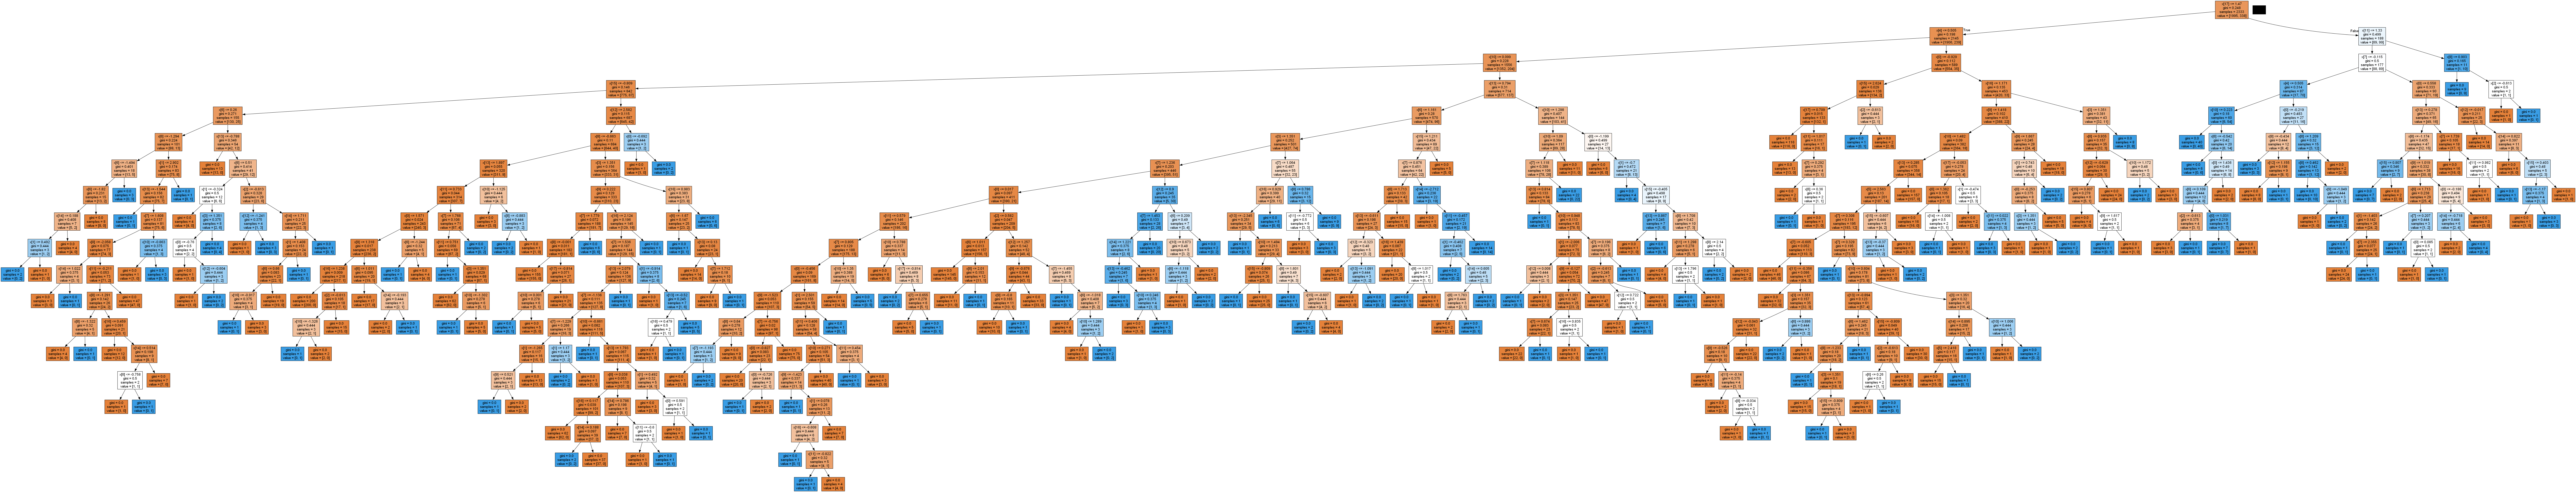

In [ ]:
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

best_tree_model = model.best_estimator_


import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

dot_data = StringIO()
single_tree = best_tree_model.estimators_[0]

export_graphviz(single_tree, out_file=dot_data, filled=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

filename = 'telecom_churn.png'
graph.write_png(filename)
Image(filename=filename) 